In [1]:
# PARAMETERS
nc_file = "../cloud_results.nc"
min_max_size_points = 100        # Track must reach at least this many voxels once
min_lifetime_steps = 3       # Track must exist (non-NaN size) at least this many timesteps
use_integrated_mass_flux = True  # If True: sum over time; else: time-mean
time_step_seconds = 60           # Needed only if you want to scale integrated flux by dt
volume_dx = 25.0                 # Horizontal grid (m)
volume_dy = 25.0                 # Horizontal grid (m)
# For voxel vertical thickness we infer per level (variable height spacing allowed)

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns

# ---------------- Core extraction & processing ---------------- #
def load_tracks(nc_path):
    def read_opt(ds, name):
        var = ds.variables.get(name)
        if var is None:
            return None
            
        # Get the data as a masked array
        data = var[:]
        
        # Handle different data types appropriately
        if np.issubdtype(data.dtype, np.integer):
            # For integer arrays, convert to float64 to support NaN
            return np.ma.filled(data.astype(np.float64), np.nan)
        else:
            # For floating point arrays, use NaN directly
            return np.ma.filled(data, np.nan)
    

    with Dataset(nc_path) as ds:
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        height = np.asarray(ds.variables['height'][:])
        
        age = read_opt(ds, 'age') 
        cloud_base_area = read_opt(ds, 'cloud_base_area')
        max_height = read_opt(ds, 'max_height')
        cloud_base_height = read_opt(ds, 'cloud_base_height')
        base_radius_diagnosed = read_opt(ds, 'base_radius_diagnosed')
        base_radius_prescribed = read_opt(ds, 'base_radius_prescribed')
        max_w_cloud_base = read_opt(ds, 'max_w_cloud_base')
        w_per_level = read_opt(ds, 'w_per_level')  # (track,time,level)
        surface_area = read_opt(ds, 'surface_area')
        

    return dict(
        valid_track=valid_track,
        size=size,
        mass_flux=mass_flux,
        merges_count=merges_count.astype(np.int32),
        splits_count=splits_count.astype(np.int32),
        height=height,
        age=age,
        cloud_base_area=cloud_base_area,
        max_height=max_height,
        cloud_base_height=cloud_base_height,
        base_radius_diagnosed=base_radius_diagnosed,
        base_radius_prescribed=base_radius_prescribed,
        max_w_cloud_base=max_w_cloud_base,
        surface_area=surface_area,
        w_per_level=w_per_level,
    )






def build_track_dataframe(data, min_max_size_points, min_lifetime_steps,
                          use_integrated_mass_flux, time_step_seconds,
                          voxel_volume_per_level=None):
    valid_mask = data['valid_track'] == 1
    size = np.asarray(data['size'])                  # already filled
    mass_flux = np.asarray(data['mass_flux'])
    merges = np.asarray(data['merges_count'])
    splits = np.asarray(data['splits_count'])

    n_tracks, n_time = size.shape
    records = []
    for i in range(n_tracks):
        if not valid_mask[i]:
            continue

        size_row = size[i]  # (time,)
        # timesteps where size is real (not NaN and >0)
        valid_timesteps = np.isfinite(size_row)
        lifetime = int(valid_timesteps.sum())
        if lifetime == 0:
            continue

        max_size = np.nanmax(size_row)
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue

        # Safe sums (arrays are plain ndarrays now)
        merges_total = int(merges[i, valid_timesteps].sum())
        splits_total = int(splits[i, valid_timesteps].sum())

        mf_row = mass_flux[i]
        if use_integrated_mass_flux:
            mf_val = np.nansum(mf_row[valid_timesteps])  # * time_step_seconds if physical time integration needed
        else:
            mf_val = float(np.nanmean(mf_row[valid_timesteps]))

        mean_size = float(np.nanmean(size_row[valid_timesteps]))

        records.append(dict(track_index=i,
                            lifetime=lifetime,
                            max_size_points=max_size,
                            mean_size_points=mean_size,
                            merges_total=merges_total,
                            splits_total=splits_total,
                            mass_flux_metric=mf_val))
    return pd.DataFrame.from_records(records)


def infer_voxel_volumes(height, dx, dy):
    # Derive per-level thickness (Δz). Last level thickness = median of previous (fallback)
    z = np.asarray(height, dtype=float)
    if z.size < 2:
        dz = np.array([1.0])
    else:
        dz_mid = np.diff(z)
        last = np.median(dz_mid)
        dz = np.concatenate([dz_mid, [last]])
    # Return per-level voxel volume (m3)
    return dx * dy * dz


def categorize_merges(df):
    def cat(m):
        if m == 0: return "0"
        if m == 1: return "1"
        if m == 2: return "2"
        return "3+"
    return df.assign(merge_class=df.merges_total.map(cat),
                     merged_flag=(df.merges_total > 0))



# ---------------- Run pipeline ---------------- #
raw = load_tracks(nc_file)
voxel_vol = infer_voxel_volumes(raw['height'], volume_dx, volume_dy)  # still optional

df_tracks = build_track_dataframe(raw,
                                  min_max_size_points=min_max_size_points,
                                  min_lifetime_steps=min_lifetime_steps,
                                  use_integrated_mass_flux=use_integrated_mass_flux,
                                  time_step_seconds=time_step_seconds)

df_tracks = categorize_merges(df_tracks)


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_77045/427141988.py:25: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(arr[idx, :], axis=1)


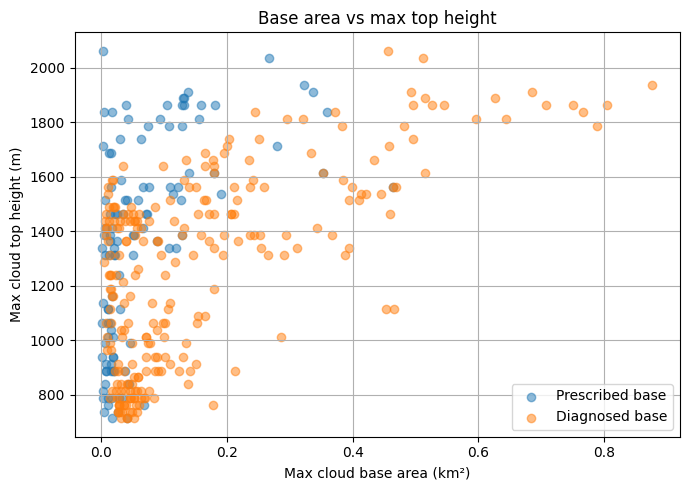

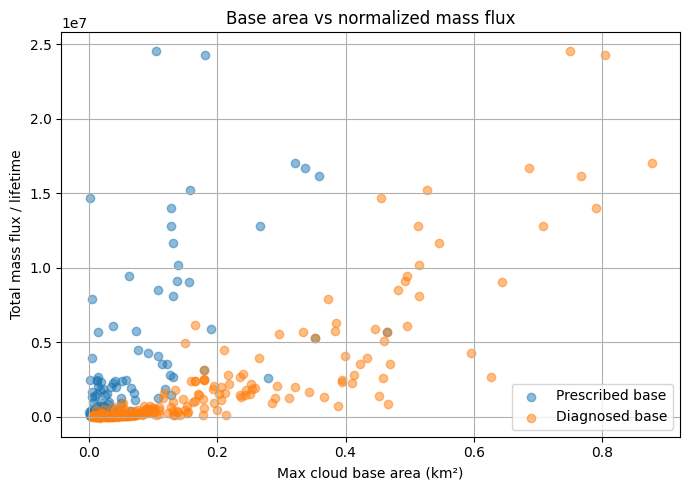

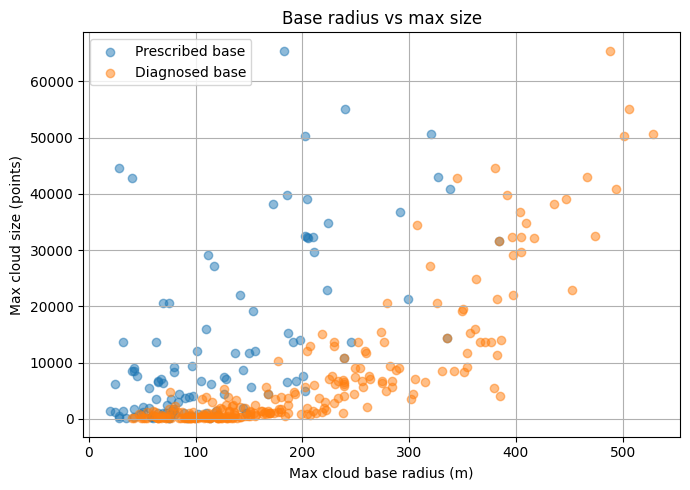

In [2]:
def extract_base_radii(raw, df_tracks):
    """
    Extract max prescribed and diagnosed base radii and top height for each track.
    Handles missing or malformed arrays gracefully.
    """
    # Defensive extraction
    prescribed = raw.get('base_radius_prescribed', None)
    diagnosed = raw.get('base_radius_diagnosed', None)
    top_height = raw.get('max_height', None)

    # Ensure arrays are present and have correct shape
    def safe_extract(arr, idx):
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            # Problem: array missing or not 2D
            # Risk: downstream IndexError, all NaN output
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Defensive: bounds check
        if arr.shape[0] < np.max(idx) + 1:
            # Problem: array too short for track indices
            # Risk: IndexError, incomplete extraction
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Extract max over time for each track
        return np.nanmax(arr[idx, :], axis=1)

    idx = df_tracks.track_index.values
    max_prescribed = safe_extract(prescribed, idx)
    max_diagnosed = safe_extract(diagnosed, idx)
    max_top_height = safe_extract(top_height, idx)
    return max_prescribed, max_diagnosed, max_top_height

max_prescribed, max_diagnosed, max_top_height = extract_base_radii(raw, df_tracks)

# Compute areas
area_prescribed = np.pi * max_prescribed**2 / 1e6  # convert to square km
area_diagnosed = np.pi * max_diagnosed**2 / 1e6

# Relationship 1: base area vs max cloud top height
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, max_top_height, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, max_top_height, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (km²)")
plt.ylabel("Max cloud top height (m)")
plt.title("Base area vs max top height")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 2: base area vs total mass flux (normalized by lifespan)
norm_mass_flux = df_tracks.mass_flux_metric / df_tracks.lifetime
plt.figure(figsize=(7,5))
plt.scatter(area_prescribed, norm_mass_flux, alpha=0.5, label='Prescribed base')
plt.scatter(area_diagnosed, norm_mass_flux, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base area (km²)")
plt.ylabel("Total mass flux / lifetime")
plt.title("Base area vs normalized mass flux")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Relationship 3: base radius vs max size
plt.figure(figsize=(7,5))
plt.scatter(max_prescribed, df_tracks.max_size_points, alpha=0.5, label='Prescribed base')
plt.scatter(max_diagnosed, df_tracks.max_size_points, alpha=0.5, label='Diagnosed base')
plt.xlabel("Max cloud base radius (m)")
plt.ylabel("Max cloud size (points)")
plt.title("Base radius vs max size")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Some linear fits on the above. 

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_77045/911454146.py:27: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(arr[idx, :], axis=1)


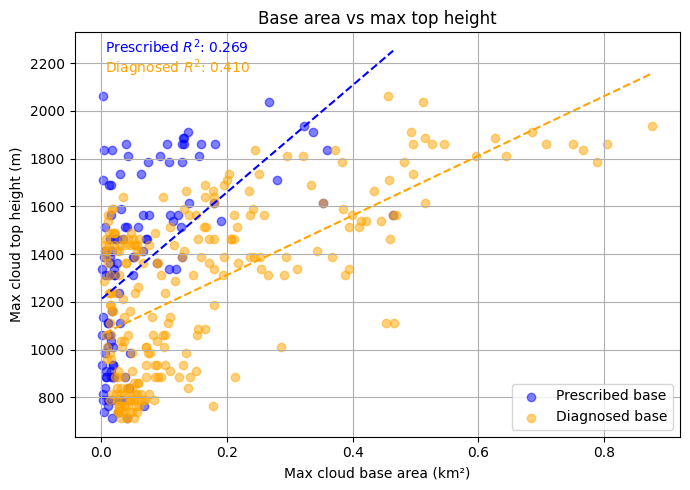

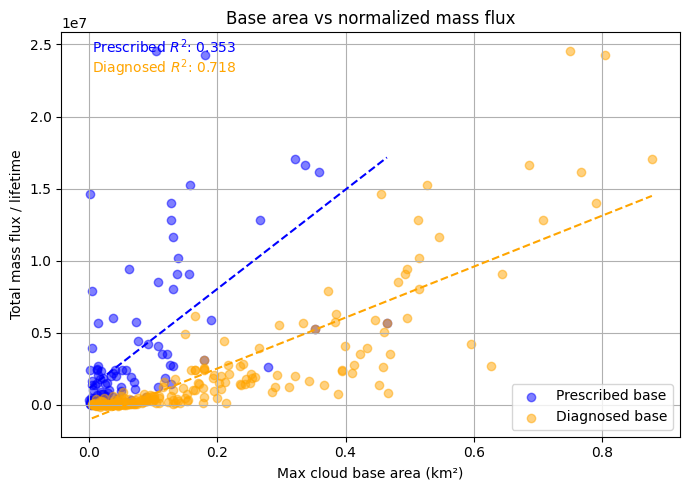

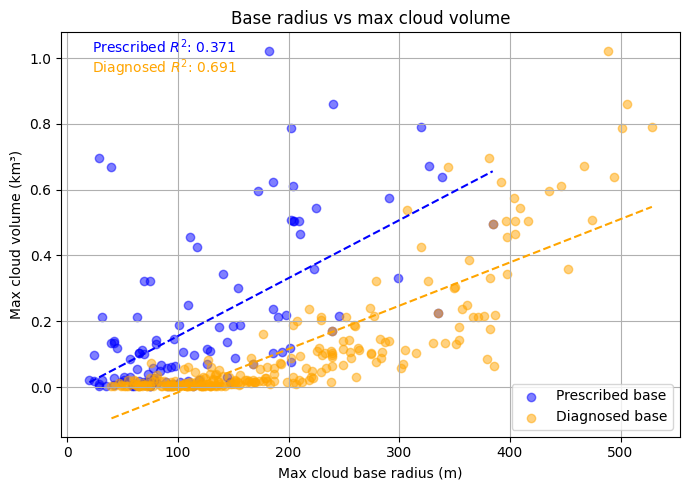

In [3]:
from scipy import stats

def extract_base_radii(raw, df_tracks):
    """
    Extract max prescribed and diagnosed base radii and top height for each track.
    Handles missing or malformed arrays gracefully.
    """
    # Defensive extraction
    prescribed = raw.get('base_radius_prescribed', None)
    diagnosed = raw.get('base_radius_diagnosed', None)
    top_height = raw.get('max_height', None)

    # Ensure arrays are present and have correct shape
    def safe_extract(arr, idx):
        if arr is None or not hasattr(arr, 'shape') or len(arr.shape) != 2:
            # Problem: array missing or not 2D
            # Risk: downstream IndexError, all NaN output
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Defensive: bounds check
        if arr.shape[0] < np.max(idx) + 1:
            # Problem: array too short for track indices
            # Risk: IndexError, incomplete extraction
            # Fix: Return NaNs for all tracks
            return np.full(len(idx), np.nan)
        # Extract max over time for each track
        return np.nanmax(arr[idx, :], axis=1)

    idx = df_tracks.track_index.values
    max_prescribed = safe_extract(prescribed, idx)
    max_diagnosed = safe_extract(diagnosed, idx)
    max_top_height = safe_extract(top_height, idx)
    return max_prescribed, max_diagnosed, max_top_height

max_prescribed, max_diagnosed, max_top_height = extract_base_radii(raw, df_tracks)

# Compute areas
area_prescribed = np.pi * max_prescribed**2 / 1e6  # convert to square km
area_diagnosed = np.pi * max_diagnosed**2 / 1e6

# Helper function to perform linear regression and add fit line
def add_linear_fit(x, y, ax, label, color):
    # Remove NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) > 1:  # Need at least 2 points for regression
        # Calculate linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        r_squared = r_value**2
        
        # Add regression line to plot
        x_line = np.array([min(x_clean), max(x_clean)])
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, color=color, linestyle='--')
        
        # Add R-squared text
        ax.text(0.05, 0.95 - 0.05 * ('Diagnosed' in label), 
                f"{label} $R^2$: {r_squared:.3f}", 
                transform=ax.transAxes, color=color)
    else:
        print(f"Warning: Not enough valid points for {label} linear fit")

# Relationship 1: base area vs max cloud top height
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.scatter(area_prescribed, max_top_height, alpha=0.5, label='Prescribed base', color='blue')
ax1.scatter(area_diagnosed, max_top_height, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(area_prescribed, max_top_height, ax1, 'Prescribed', 'blue')
add_linear_fit(area_diagnosed, max_top_height, ax1, 'Diagnosed', 'orange')

ax1.set_xlabel("Max cloud base area (km²)")
ax1.set_ylabel("Max cloud top height (m)")
ax1.set_title("Base area vs max top height")
ax1.legend(loc='lower right')
ax1.grid(True)
plt.tight_layout()

# Relationship 2: base area vs total mass flux (normalized by lifespan)
norm_mass_flux = df_tracks.mass_flux_metric / df_tracks.lifetime
fig2, ax2 = plt.subplots(figsize=(7,5))
ax2.scatter(area_prescribed, norm_mass_flux, alpha=0.5, label='Prescribed base', color='blue')
ax2.scatter(area_diagnosed, norm_mass_flux, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(area_prescribed, norm_mass_flux, ax2, 'Prescribed', 'blue')
add_linear_fit(area_diagnosed, norm_mass_flux, ax2, 'Diagnosed', 'orange')

ax2.set_xlabel("Max cloud base area (km²)")
ax2.set_ylabel("Total mass flux / lifetime")
ax2.set_title("Base area vs normalized mass flux")
ax2.legend(loc='lower right')
ax2.grid(True)
plt.tight_layout()

# Relationship 3: base radius vs max size in cubic kilometers
fig3, ax3 = plt.subplots(figsize=(7,5))

# Calculate the average voxel volume
# Note: You mentioned each voxel is 25*25*25 m³, but the code actually infers
# variable heights per level, so we'll calculate an average
mean_voxel_volume = np.mean(voxel_vol)  # in cubic meters

# Convert max size from points to cubic kilometers
max_size_km3 = df_tracks.max_size_points * mean_voxel_volume / 1e9

# Create scatter plot with converted units
ax3.scatter(max_prescribed, max_size_km3, alpha=0.5, label='Prescribed base', color='blue')
ax3.scatter(max_diagnosed, max_size_km3, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(max_prescribed, max_size_km3, ax3, 'Prescribed', 'blue')
add_linear_fit(max_diagnosed, max_size_km3, ax3, 'Diagnosed', 'orange')

ax3.set_xlabel("Max cloud base radius (m)")
ax3.set_ylabel("Max cloud volume (km³)")
ax3.set_title("Base radius vs max cloud volume")
ax3.legend(loc='lower right')
ax3.grid(True)
plt.tight_layout()

plt.show()

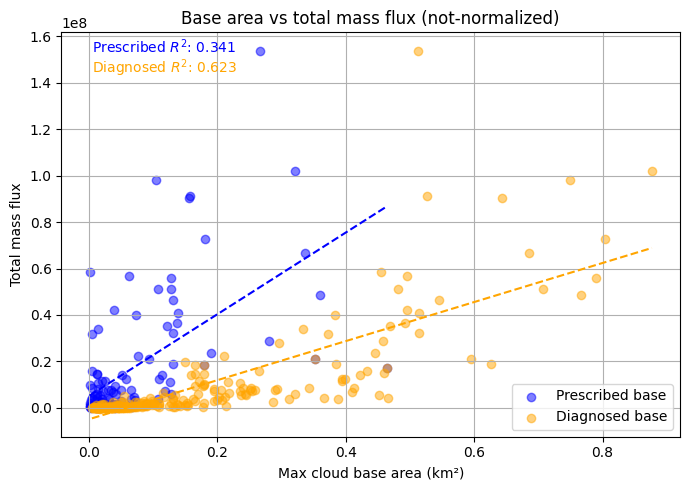

In [4]:
# Relationship 2a: base area vs total mass flux (unnormalized)
fig2a, ax2a = plt.subplots(figsize=(7,5))
ax2a.scatter(area_prescribed, df_tracks.mass_flux_metric, alpha=0.5, label='Prescribed base', color='blue')
ax2a.scatter(area_diagnosed, df_tracks.mass_flux_metric, alpha=0.5, label='Diagnosed base', color='orange')

# Add linear fits
add_linear_fit(area_prescribed, df_tracks.mass_flux_metric, ax2a, 'Prescribed', 'blue')
add_linear_fit(area_diagnosed, df_tracks.mass_flux_metric, ax2a, 'Diagnosed', 'orange')

ax2a.set_xlabel("Max cloud base area (km²)")
ax2a.set_ylabel("Total mass flux")
ax2a.set_title("Base area vs total mass flux (not-normalized)")
ax2a.legend(loc='lower right')
ax2a.grid(True)
plt.tight_layout()

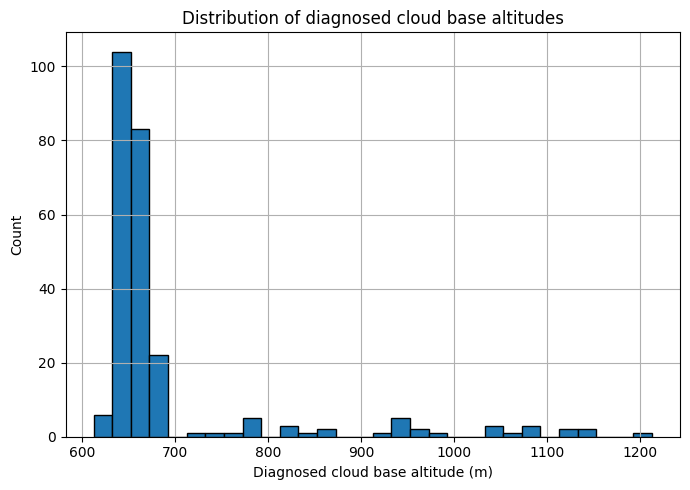

In [5]:
base_altitude = np.ma.filled(raw.get('cloud_base_height', None), np.nan)
idx = df_tracks.track_index.values
min_base_altitude = np.nanmin(base_altitude[idx, :], axis=1)
plt.figure(figsize=(7,5))
plt.hist(min_base_altitude[~np.isnan(min_base_altitude)], bins=30, edgecolor='black')
plt.xlabel("Diagnosed cloud base altitude (m)")
plt.ylabel("Count")
plt.title("Distribution of diagnosed cloud base altitudes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Detachment of clouds base, or not?

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_77045/1782146688.py:32: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  (tracks_df.max_size_points >= min_cloud_size) &


Filtered from 250 to 77 clouds (min size: 10, min lifetime: 5, only valid tracks)


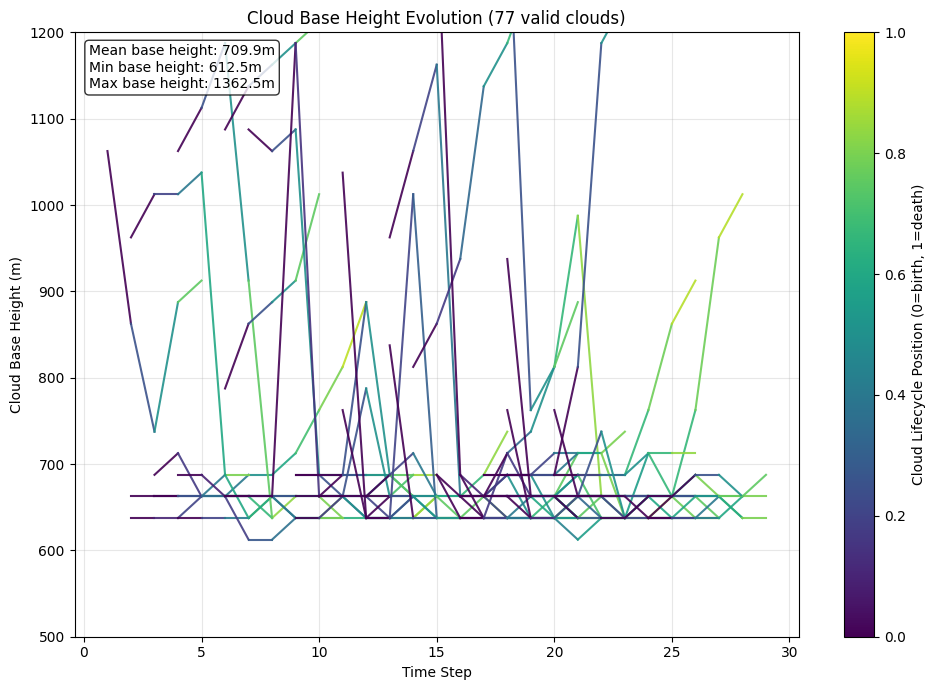

In [6]:
# Function to plot cloud base height evolution with improved filtering
def plot_cloud_base_height_evolution(raw_data, tracks_df, 
                                    min_cloud_size=100,       # Min size in points
                                    min_lifetime=3,           # Min lifetime in timesteps
                                    max_clouds=None,          # Max clouds to plot
                                    alpha=0.3,                # Line transparency
                                    height_range=None):       # Optional y-axis range
    """
    Plot the evolution of cloud base height over time for each valid cloud track.
    
    Parameters:
    - raw_data: Dictionary containing the cloud_base_height array
    - tracks_df: DataFrame with filtered valid tracks
    - min_cloud_size: Minimum max size (in points) for clouds to include
    - min_lifetime: Minimum lifetime (in timesteps) for clouds to include
    - max_clouds: Maximum number of clouds to plot (None = all)
    - alpha: Transparency for individual cloud lines
    - height_range: Optional tuple of (min_height, max_height) to constrain y-axis
    """
    # Extract cloud base height data
    base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    
    if base_height is None:
        print("Cloud base height data not available")
        return
    
    # Get valid tracks mask from raw data to ensure we only use non-tainted tracks
    valid_tracks_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Apply size, lifetime, and valid track filters
    filtered_df = tracks_df[
        (tracks_df.max_size_points >= min_cloud_size) & 
        (tracks_df.lifetime >= min_lifetime) &
        # Only include track indices that are marked as valid
        [valid_tracks_mask[idx] for idx in tracks_df.track_index.values]
    ].copy()
    
    print(f"Filtered from {len(tracks_df)} to {len(filtered_df)} clouds "
          f"(min size: {min_cloud_size}, min lifetime: {min_lifetime}, only valid tracks)")
    
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get track indices from filtered dataframe
    track_indices = filtered_df.track_index.values
    
    # Limit number of plotted clouds if requested
    if max_clouds is not None and max_clouds < len(track_indices):
        # Use consistently longest-lived clouds for better visualization
        idx = np.argsort(-filtered_df.lifetime.values)[:max_clouds]
        track_indices = track_indices[idx]
    
    # Color map for cloud lifecycle stage
    cmap = plt.cm.viridis
    
    # Counter for plotted tracks
    plotted = 0
    
    # Plot each cloud's base height evolution
    for i, idx in enumerate(track_indices):
        # Extract time series for this cloud
        heights = base_height[idx, :]
        
        # Find valid timesteps (where height is not NaN)
        valid_mask = ~np.isnan(heights)
        if not np.any(valid_mask):
            continue
        
        # Get timesteps (relative to cloud's own lifecycle)
        timesteps = np.arange(len(heights))[valid_mask]
        cloud_heights = heights[valid_mask]
        
        # Normalize lifecycle position for coloring (0=birth, 1=death)
        positions = np.linspace(0, 1, len(timesteps))
        
        # Plot with color based on lifecycle position
        for j in range(len(timesteps)-1):
            ax.plot(timesteps[j:j+2], cloud_heights[j:j+2], 
                   color=cmap(positions[j]), linewidth=1.5, alpha=alpha)
        
        plotted += 1
    
    # Add a colorbar to show lifecycle stage
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cloud Lifecycle Position (0=birth, 1=death)')
    
    # Add annotations
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Cloud Base Height (m)')
    ax.set_title(f'Cloud Base Height Evolution ({plotted} valid clouds)')
    
    # Set height range if provided
    if height_range is not None:
        ax.set_ylim(height_range)
    
    # Add a horizontal line at the model cloud base level (if available)
    cloud_base_altitude = raw_data.get('config_cloud_base_altitude', None)
    if cloud_base_altitude is not None:
        ax.axhline(y=cloud_base_altitude, color='r', linestyle='--', alpha=0.7, 
                  label=f'Model Cloud Base: {cloud_base_altitude}m')
        ax.legend()
    
    # Calculate statistics for the plotted clouds
    if plotted > 0:
        mean_base_height = np.nanmean([np.nanmean(base_height[idx, :]) for idx in track_indices[:plotted]])
        min_base_height = np.nanmin([np.nanmin(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        max_base_height = np.nanmax([np.nanmax(base_height[idx, :]) for idx in track_indices[:plotted]])
        
        # Add statistics text to the plot
        stats_text = (f"Mean base height: {mean_base_height:.1f}m\n"
                      f"Min base height: {min_base_height:.1f}m\n"
                      f"Max base height: {max_base_height:.1f}m")
        
        # Position text in upper left corner
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax

# Example usage with different filtering settings
fig1, ax1 = plot_cloud_base_height_evolution(
    raw, df_tracks, 
    min_cloud_size=10,     # Only clouds with significant size
    min_lifetime=5,         # Clouds that exist for at least 5 timesteps
    max_clouds=200,          # Limit number of clouds for clarity
    alpha=0.9,              # Moderate transparency
    height_range=(500, 1200) # Focus on typical cloud base region
)
plt.show()

### Pull all lifespans to start at time 0.

Filtered from 250 to 77 clouds (min size: 10, min lifetime: 5, only valid tracks)


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_77045/2067363155.py:33: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  (tracks_df.max_size_points >= min_cloud_size) &


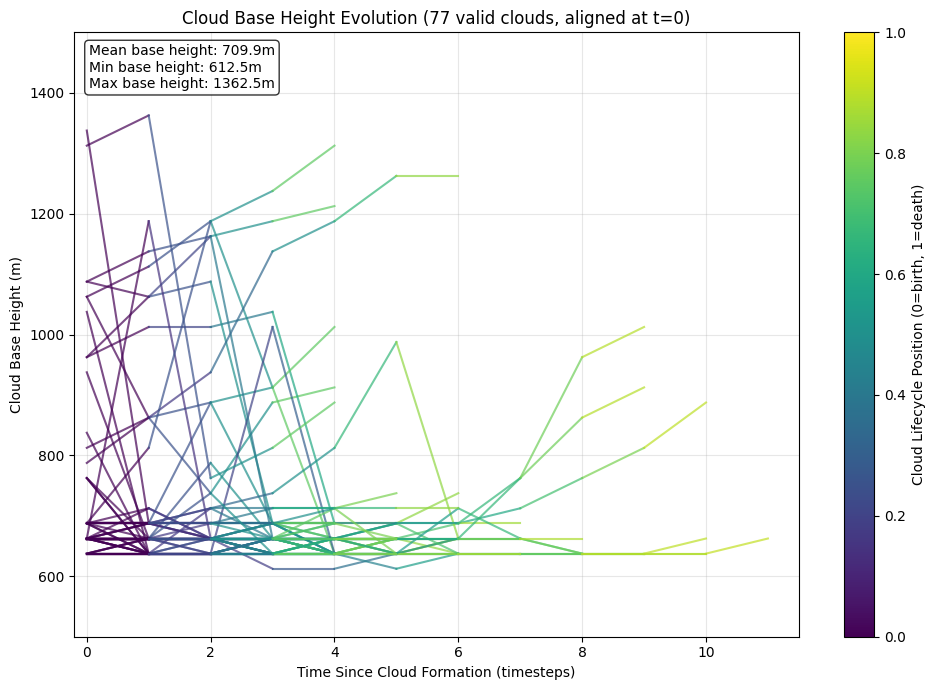

In [7]:
# Function to plot cloud base height evolution with all timelines aligned to t=0
def plot_cloud_base_height_evolution(raw_data, tracks_df, 
                                    min_cloud_size=100,       # Min size in points
                                    min_lifetime=3,           # Min lifetime in timesteps
                                    max_clouds=None,          # Max clouds to plot
                                    alpha=0.3,                # Line transparency
                                    height_range=None):       # Optional y-axis range
    """
    Plot the evolution of cloud base height over time for each valid cloud track,
    with all timelines aligned to start at t=0 for easier comparison.
    
    Parameters:
    - raw_data: Dictionary containing the cloud_base_height array
    - tracks_df: DataFrame with filtered valid tracks
    - min_cloud_size: Minimum max size (in points) for clouds to include
    - min_lifetime: Minimum lifetime (in timesteps) for clouds to include
    - max_clouds: Maximum number of clouds to plot (None = all)
    - alpha: Transparency for individual cloud lines
    - height_range: Optional tuple of (min_height, max_height) to constrain y-axis
    """
    # Extract cloud base height data
    base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    
    if base_height is None:
        print("Cloud base height data not available")
        return
    
    # Get valid tracks mask from raw data to ensure we only use non-tainted tracks
    valid_tracks_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Apply size, lifetime, and valid track filters
    filtered_df = tracks_df[
        (tracks_df.max_size_points >= min_cloud_size) & 
        (tracks_df.lifetime >= min_lifetime) &
        # Only include track indices that are marked as valid
        [valid_tracks_mask[idx] for idx in tracks_df.track_index.values]
    ].copy()
    
    print(f"Filtered from {len(tracks_df)} to {len(filtered_df)} clouds "
          f"(min size: {min_cloud_size}, min lifetime: {min_lifetime}, only valid tracks)")
    
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get track indices from filtered dataframe
    track_indices = filtered_df.track_index.values
    
    # Limit number of plotted clouds if requested
    if max_clouds is not None and max_clouds < len(track_indices):
        # Use consistently longest-lived clouds for better visualization
        idx = np.argsort(-filtered_df.lifetime.values)[:max_clouds]
        track_indices = track_indices[idx]
    
    # Color map for cloud lifecycle stage
    cmap = plt.cm.viridis
    
    # Counter for plotted tracks and tracking maximum lifetime
    plotted = 0
    max_lifetime = 0
    
    # Plot each cloud's base height evolution
    for i, idx in enumerate(track_indices):
        # Extract time series for this cloud
        heights = base_height[idx, :]
        
        # Find valid timesteps (where height is not NaN)
        valid_mask = ~np.isnan(heights)
        if not np.any(valid_mask):
            continue
        
        # Get original timesteps where cloud data exists
        original_timesteps = np.arange(len(heights))[valid_mask]
        cloud_heights = heights[valid_mask]
        
        # Normalize the timesteps to start at 0 for this cloud
        relative_timesteps = original_timesteps - original_timesteps[0]
        
        # Track maximum lifetime for x-axis scale
        max_lifetime = max(max_lifetime, relative_timesteps[-1])
        
        # Normalize lifecycle position for coloring (0=birth, 1=death)
        positions = np.linspace(0, 1, len(relative_timesteps))
        
        # Plot with color based on lifecycle position
        for j in range(len(relative_timesteps)-1):
            ax.plot(relative_timesteps[j:j+2], cloud_heights[j:j+2], 
                   color=cmap(positions[j]), linewidth=1.5, alpha=alpha)
        
        plotted += 1
    
    # Add a colorbar to show lifecycle stage
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cloud Lifecycle Position (0=birth, 1=death)')
    
    # Add annotations
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Since Cloud Formation (timesteps)')
    ax.set_ylabel('Cloud Base Height (m)')
    ax.set_title(f'Cloud Base Height Evolution ({plotted} valid clouds, aligned at t=0)')
    
    # Set height range if provided
    if height_range is not None:
        ax.set_ylim(height_range)
    
    # Add a horizontal line at the model cloud base level (if available)
    cloud_base_altitude = raw_data.get('config_cloud_base_altitude', None)
    if cloud_base_altitude is not None:
        ax.axhline(y=cloud_base_altitude, color='r', linestyle='--', alpha=0.7, 
                  label=f'Model Cloud Base: {cloud_base_altitude}m')
        ax.legend()
    
    # Calculate statistics for the plotted clouds
    if plotted > 0:
        mean_base_height = np.nanmean([np.nanmean(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                     for idx in track_indices[:plotted]])
        min_base_height = np.nanmin([np.nanmin(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        max_base_height = np.nanmax([np.nanmax(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        
        # Add statistics text to the plot
        stats_text = (f"Mean base height: {mean_base_height:.1f}m\n"
                      f"Min base height: {min_base_height:.1f}m\n"
                      f"Max base height: {max_base_height:.1f}m")
        
        # Position text in upper left corner
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ensure x-axis starts at 0 and add a bit of padding
    ax.set_xlim(-0.2, max_lifetime + 0.5)
    
    plt.tight_layout()
    return fig, ax

# Example usage with different filtering settings
fig1, ax1 = plot_cloud_base_height_evolution(
    raw, df_tracks, 
    min_cloud_size=10,      # Only clouds with significant size
    min_lifetime=5,          # Clouds that exist for at least 5 timesteps
    max_clouds=1000,           # Limit number of clouds for clarity
    alpha=0.7,               # Moderate transparency
    height_range=(500, 1500) # Focus on typical cloud base region
)
plt.show()

Just to see how it looks, removing all cloudbases that start above 700m. 

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_77045/1562447384.py:36: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  (tracks_df.max_size_points >= min_cloud_size) &


Filtered from 250 to 77 clouds (min size: 10, min lifetime: 5, only valid tracks)
Filtered out 16 clouds with initial height > 700m
Plotting 61 clouds with initial height ≤ 700m


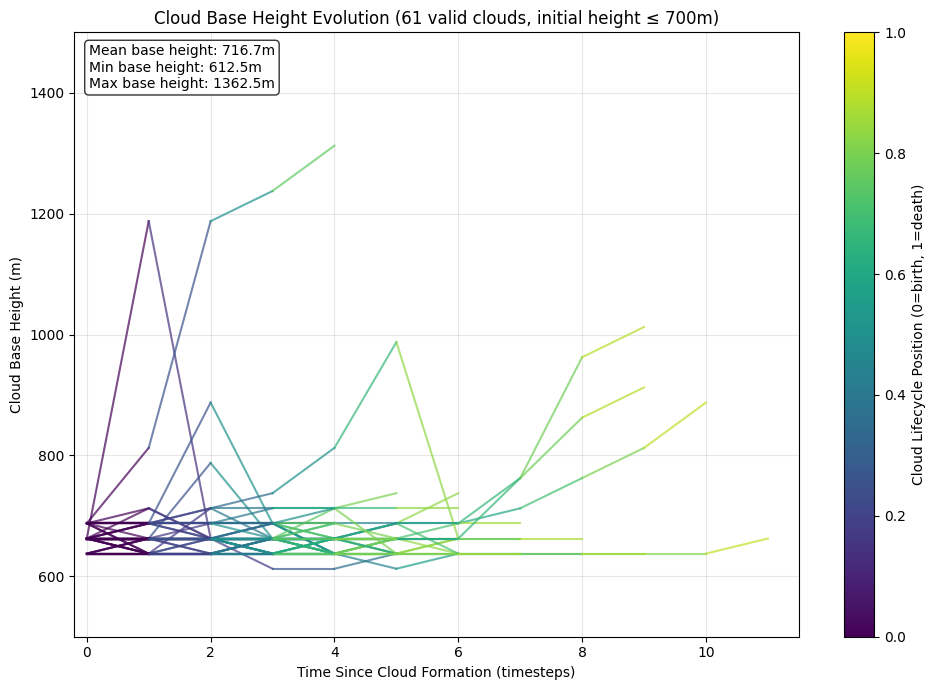

In [8]:
# Function to plot cloud base height evolution with all timelines aligned to t=0
# and filtering clouds that start above max_initial_height
def plot_cloud_base_height_evolution(raw_data, tracks_df, 
                                    min_cloud_size=100,       # Min size in points
                                    min_lifetime=3,           # Min lifetime in timesteps
                                    max_clouds=None,          # Max clouds to plot
                                    alpha=0.3,                # Line transparency
                                    height_range=None,        # Optional y-axis range
                                    max_initial_height=700):  # Max allowed initial cloud base height
    """
    Plot the evolution of cloud base height over time for each valid cloud track,
    with all timelines aligned to start at t=0 for easier comparison.
    
    Parameters:
    - raw_data: Dictionary containing the cloud_base_height array
    - tracks_df: DataFrame with filtered valid tracks
    - min_cloud_size: Minimum max size (in points) for clouds to include
    - min_lifetime: Minimum lifetime (in timesteps) for clouds to include
    - max_clouds: Maximum number of clouds to plot (None = all)
    - alpha: Transparency for individual cloud lines
    - height_range: Optional tuple of (min_height, max_height) to constrain y-axis
    - max_initial_height: Maximum allowed initial cloud base height (m)
    """
    # Extract cloud base height data
    base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    
    if base_height is None:
        print("Cloud base height data not available")
        return
    
    # Get valid tracks mask from raw data to ensure we only use non-tainted tracks
    valid_tracks_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Apply size, lifetime, and valid track filters
    filtered_df = tracks_df[
        (tracks_df.max_size_points >= min_cloud_size) & 
        (tracks_df.lifetime >= min_lifetime) &
        # Only include track indices that are marked as valid
        [valid_tracks_mask[idx] for idx in tracks_df.track_index.values]
    ].copy()
    
    print(f"Filtered from {len(tracks_df)} to {len(filtered_df)} clouds "
          f"(min size: {min_cloud_size}, min lifetime: {min_lifetime}, only valid tracks)")
    
    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get track indices from filtered dataframe
    track_indices = filtered_df.track_index.values
    
    # Limit number of plotted clouds if requested
    if max_clouds is not None and max_clouds < len(track_indices):
        # Use consistently longest-lived clouds for better visualization
        idx = np.argsort(-filtered_df.lifetime.values)[:max_clouds]
        track_indices = track_indices[idx]
    
    # Color map for cloud lifecycle stage
    cmap = plt.cm.viridis
    
    # Counter for plotted tracks and tracking maximum lifetime
    plotted = 0
    filtered_by_height = 0
    max_lifetime = 0
    
    # Plot each cloud's base height evolution
    for i, idx in enumerate(track_indices):
        # Extract time series for this cloud
        heights = base_height[idx, :]
        
        # Find valid timesteps (where height is not NaN)
        valid_mask = ~np.isnan(heights)
        if not np.any(valid_mask):
            continue
        
        # Get original timesteps where cloud data exists
        original_timesteps = np.arange(len(heights))[valid_mask]
        cloud_heights = heights[valid_mask]
        
        # Filter clouds that start above max_initial_height
        if cloud_heights[0] > max_initial_height:
            filtered_by_height += 1
            continue
            
        # Normalize the timesteps to start at 0 for this cloud
        relative_timesteps = original_timesteps - original_timesteps[0]
        
        # Track maximum lifetime for x-axis scale
        max_lifetime = max(max_lifetime, relative_timesteps[-1])
        
        # Normalize lifecycle position for coloring (0=birth, 1=death)
        positions = np.linspace(0, 1, len(relative_timesteps))
        
        # Plot with color based on lifecycle position
        for j in range(len(relative_timesteps)-1):
            ax.plot(relative_timesteps[j:j+2], cloud_heights[j:j+2], 
                   color=cmap(positions[j]), linewidth=1.5, alpha=alpha)
        
        plotted += 1
    
    # Print height filtering statistics
    print(f"Filtered out {filtered_by_height} clouds with initial height > {max_initial_height}m")
    print(f"Plotting {plotted} clouds with initial height ≤ {max_initial_height}m")
    
    # Add a colorbar to show lifecycle stage
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Cloud Lifecycle Position (0=birth, 1=death)')
    
    # Add annotations
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Time Since Cloud Formation (timesteps)')
    ax.set_ylabel('Cloud Base Height (m)')
    ax.set_title(f'Cloud Base Height Evolution ({plotted} valid clouds, initial height ≤ {max_initial_height}m)')
    
    # Set height range if provided
    if height_range is not None:
        ax.set_ylim(height_range)
    
    # Add a horizontal line at the model cloud base level (if available)
    cloud_base_altitude = raw_data.get('config_cloud_base_altitude', None)
    if cloud_base_altitude is not None:
        ax.axhline(y=cloud_base_altitude, color='r', linestyle='--', alpha=0.7, 
                  label=f'Model Cloud Base: {cloud_base_altitude}m')
        ax.legend()
    
    # Calculate statistics for the plotted clouds
    if plotted > 0:
        mean_base_height = np.nanmean([np.nanmean(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                     for idx in track_indices[:plotted]])
        min_base_height = np.nanmin([np.nanmin(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        max_base_height = np.nanmax([np.nanmax(base_height[idx, :][~np.isnan(base_height[idx, :])]) 
                                   for idx in track_indices[:plotted]])
        
        # Add statistics text to the plot
        stats_text = (f"Mean base height: {mean_base_height:.1f}m\n"
                      f"Min base height: {min_base_height:.1f}m\n"
                      f"Max base height: {max_base_height:.1f}m")
        
        # Position text in upper left corner
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Ensure x-axis starts at 0 and add a bit of padding
    ax.set_xlim(-0.2, max_lifetime + 0.5)
    
    plt.tight_layout()
    return fig, ax

# Example usage with different filtering settings
fig1, ax1 = plot_cloud_base_height_evolution(
    raw, df_tracks, 
    min_cloud_size=10,       # Only clouds with significant size
    min_lifetime=5,          # Clouds that exist for at least 5 timesteps
    max_clouds=1000,         # Limit number of clouds for clarity
    alpha=0.7,               # Moderate transparency
    height_range=(500, 1500),# Focus on typical cloud base region
    max_initial_height=700   # Only show clouds that start below 700m
)
plt.show()

# Cloud base detachment fraction of clouds

In [12]:
def analyze_cloud_base_detachment_with_lifespan_plots(raw_data, tracks_df, 
                                                    detachment_threshold=50,
                                                    min_lifetime_steps=3,
                                                    min_size_points=10):
    """
    Analyze cloud base detachment with enhanced lifespan visualizations.
    
    Parameters:
    - raw_data: Dictionary with cloud tracking data
    - tracks_df: DataFrame with filtered valid tracks
    - detachment_threshold: Height (m) increase to consider "detached" for diagnosed
    - min_lifetime_steps: Minimum cloud lifetime
    - min_size_points: Minimum cloud size
    
    Returns:
    - Dictionary with detachment statistics and creates separate visualizations
    """
    # Get required data
    diag_base_height = np.ma.filled(raw_data.get('cloud_base_height', None), np.nan)
    pres_base_radius = np.ma.filled(raw_data.get('base_radius_prescribed', None), np.nan)
    size = np.ma.filled(raw_data.get('size', None), np.nan)
    valid_track_mask = raw_data.get('valid_track', np.ones(len(tracks_df))) == 1
    
    # Get the age data - this is a 2D array (track, time)
    age = np.ma.filled(raw_data.get('age', None), np.nan)
    if age is None:
        print("Warning: Age data not available. Using lifetime from size instead.")
        use_age_data = False
    else:
        use_age_data = True
    
    # Filter for valid tracks
    track_indices = []
    for i, row in tracks_df.iterrows():
        idx = row.track_index
        if valid_track_mask[idx] and row.lifetime >= min_lifetime_steps and row.max_size_points >= min_size_points:
            track_indices.append(idx)
    
    # Initialize collections for results
    # Diagnosed method
    diag_tracks_analyzed = []
    diag_detached_tracks = []
    diag_attached_tracks = []
    diag_detachment_timestep = []  # Actual timestep when detachment occurs
    diag_detachment_normalized = []  # Normalized position (0-1)
    diag_lifespans_detached = []
    diag_lifespans_attached = []
    diag_ages_at_detachment = []  # Age at detachment time
    diag_ages_at_birth = []  # Initial age of clouds that eventually detach
    diag_max_ages_detached = []  # Maximum age reached for detached clouds
    diag_max_ages_attached = []  # Maximum age reached for attached clouds
    
    # Prescribed method
    pres_tracks_analyzed = []
    pres_detached_tracks = []
    pres_attached_tracks = []
    pres_detachment_timestep = []
    pres_detachment_normalized = []
    pres_lifespans_detached = []
    pres_lifespans_attached = []
    pres_ages_at_detachment = []  # Age at detachment time
    pres_ages_at_birth = []  # Initial age of clouds that eventually detach
    pres_max_ages_detached = []  # Maximum age reached for detached clouds
    pres_max_ages_attached = []  # Maximum age reached for attached clouds
    
    # Analyze each track
    for idx in track_indices:
        # Extract data
        diag_heights = diag_base_height[idx, :]
        pres_radii = pres_base_radius[idx, :]
        track_size = size[idx, :]
        
        # Extract cloud age at each timestep if available
        if use_age_data:
            track_ages = age[idx, :]
        
        # Find valid timesteps (where size is not NaN)
        valid_timesteps = ~np.isnan(track_size)
        valid_timesteps_indices = np.where(valid_timesteps)[0]
        
        if len(valid_timesteps_indices) < min_lifetime_steps:
            continue
            
        first_valid_idx = valid_timesteps_indices[0]
        last_valid_idx = valid_timesteps_indices[-1]
        total_lifespan = np.sum(valid_timesteps)
        
        # ------------- Diagnosed Base Analysis -------------
        # Filter out NaN values for diagnosed method
        diag_valid_mask = ~np.isnan(diag_heights)
        if np.sum(diag_valid_mask) >= min_lifetime_steps:
            # Track is valid for diagnosed analysis
            diag_tracks_analyzed.append(idx)
            
            # Extract height data for valid timesteps
            track_timesteps = np.arange(len(diag_heights))[diag_valid_mask]
            diag_track_heights = diag_heights[diag_valid_mask]
            
            # Use the initial height as reference
            initial_height_diag = diag_track_heights[0]
            
            # Find first point of detachment (if any)
            detached_indices_diag = np.where(diag_track_heights > (initial_height_diag + detachment_threshold))[0]
            
            if len(detached_indices_diag) > 0:
                # Cloud detached at some point
                diag_detached_tracks.append(idx)
                
                # Record when detachment occurs
                first_detachment_idx_diag = detached_indices_diag[0]
                detachment_timestep = track_timesteps[first_detachment_idx_diag]
                diag_detachment_timestep.append(detachment_timestep)
                diag_detachment_normalized.append(first_detachment_idx_diag / len(track_timesteps))
                
                # Store lifespan
                diag_lifespans_detached.append(len(track_timesteps))
                
                # Store age information if available
                if use_age_data:
                    # Get ages at key points in cloud lifecycle
                    birth_age = track_ages[first_valid_idx]
                    detachment_age = track_ages[detachment_timestep]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    
                    diag_ages_at_birth.append(birth_age)
                    diag_ages_at_detachment.append(detachment_age)
                    diag_max_ages_detached.append(max_age)
            else:
                # Cloud stayed attached
                diag_attached_tracks.append(idx)
                diag_lifespans_attached.append(len(track_timesteps))
                
                # Store age information if available
                if use_age_data:
                    birth_age = track_ages[first_valid_idx]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    diag_max_ages_attached.append(max_age)
        
        # ------------- Prescribed Base Analysis -------------
        # Find where cloud has points at the prescribed base (not NaN)
        has_points_at_base = ~np.isnan(pres_radii)
        
        # Only consider clouds that have points at the base at some point
        if np.any(has_points_at_base) and has_points_at_base[first_valid_idx]:
            # Track is valid for prescribed analysis
            pres_tracks_analyzed.append(idx)
            
            # Check if the cloud loses contact with the base after initially having it
            detached = False
            detachment_timestep = None
            
            for t in range(first_valid_idx + 1, len(pres_radii)):
                if valid_timesteps[t] and not has_points_at_base[t]:
                    detached = True
                    detachment_timestep = t
                    # Record when detachment occurs
                    pres_detachment_timestep.append(t)
                    pres_detachment_normalized.append((t - first_valid_idx) / total_lifespan)
                    break
            
            if detached:
                pres_detached_tracks.append(idx)
                pres_lifespans_detached.append(total_lifespan)
                
                # Store age information if available
                if use_age_data and detachment_timestep is not None:
                    birth_age = track_ages[first_valid_idx]
                    detachment_age = track_ages[detachment_timestep]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    
                    pres_ages_at_birth.append(birth_age)
                    pres_ages_at_detachment.append(detachment_age)
                    pres_max_ages_detached.append(max_age)
            else:
                pres_attached_tracks.append(idx)
                pres_lifespans_attached.append(total_lifespan)
                
                # Store age information if available
                if use_age_data:
                    birth_age = track_ages[first_valid_idx]
                    max_age = np.nanmax(track_ages[valid_timesteps])
                    pres_max_ages_attached.append(max_age)
    
    # Calculate percentages
    diag_total = len(diag_tracks_analyzed)
    diag_detached_count = len(diag_detached_tracks)
    diag_detached_pct = (diag_detached_count / diag_total * 100) if diag_total > 0 else 0
    diag_attached_pct = 100 - diag_detached_pct
    
    pres_total = len(pres_tracks_analyzed)
    pres_detached_count = len(pres_detached_tracks)
    pres_detached_pct = (pres_detached_count / pres_total * 100) if pres_total > 0 else 0
    pres_attached_pct = 100 - pres_detached_pct
    
    # Create result dictionary
    results = {
        'diag_total': diag_total,
        'diag_detached': diag_detached_count,
        'diag_detached_pct': diag_detached_pct,
        'diag_attached_pct': diag_attached_pct,
        
        'pres_total': pres_total,
        'pres_detached': pres_detached_count,
        'pres_detached_pct': pres_detached_pct,
        'pres_attached_pct': pres_attached_pct,
        
        'diag_threshold_m': detachment_threshold,
        'min_lifetime_steps': min_lifetime_steps,
        'min_size_points': min_size_points,
        
        # Additional data for plots
        'diag_detachment_timestep': diag_detachment_timestep,
        'diag_detachment_normalized': diag_detachment_normalized,
        'diag_lifespans_detached': diag_lifespans_detached,
        'diag_lifespans_attached': diag_lifespans_attached,
        
        # Age information (with correct interpretation)
        'diag_ages_at_birth': diag_ages_at_birth,
        'diag_ages_at_detachment': diag_ages_at_detachment,
        'diag_max_ages_detached': diag_max_ages_detached,
        'diag_max_ages_attached': diag_max_ages_attached,
        
        'pres_detachment_timestep': pres_detachment_timestep,
        'pres_detachment_normalized': pres_detachment_normalized,
        'pres_lifespans_detached': pres_lifespans_detached,
        'pres_lifespans_attached': pres_lifespans_attached,
        
        # Age information (with correct interpretation)
        'pres_ages_at_birth': pres_ages_at_birth,
        'pres_ages_at_detachment': pres_ages_at_detachment,
        'pres_max_ages_detached': pres_max_ages_detached,
        'pres_max_ages_attached': pres_max_ages_attached,
        
        'use_age_data': use_age_data
    }
    
    # Create visualizations
    create_lifespan_visualizations(results)
    
    return results


def create_lifespan_visualizations(results):
    """
    Create detailed visualizations for cloud lifespan and detachment analysis.
    
    Parameters:
    - results: Dictionary with detachment analysis results
    """
    # Create a figure with 2x2 plots
    fig = plt.figure(figsize=(15, 10))
    
    # Helper function to ensure 1D array format
    def ensure_1d_array(data):
        if data is None or len(data) == 0:
            return np.array([])
        data_array = np.asarray(data)
        if data_array.ndim > 1:
            # If multidimensional, flatten to 1D
            return data_array.flatten()
        return data_array
    
    # 1. When do clouds detach? (Normalized 0-1 in cloud lifecycle)
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    diag_detach_norm = ensure_1d_array(results['diag_detachment_normalized'])
    pres_detach_norm = ensure_1d_array(results['pres_detachment_normalized'])
    
    if len(diag_detach_norm) > 0 and len(pres_detach_norm) > 0:
        ax1.hist([diag_detach_norm, pres_detach_norm], 
                bins=10, range=(0, 1), 
                label=['Diagnosed', 'Prescribed'],
                alpha=0.7, color=['skyblue', 'salmon'])
        ax1.set_xlabel('Cloud Lifecycle Position (0=birth, 1=death)')
        ax1.set_ylabel('Count')
        ax1.set_title('When Do Clouds Detach Within Their Lifecycle?')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add statistics
        diag_avg = np.mean(diag_detach_norm)
        pres_avg = np.mean(pres_detach_norm)
        stats_text = f"Average detachment time:\nDiagnosed: {diag_avg:.2f}\nPrescribed: {pres_avg:.2f}"
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax1.text(0.5, 0.5, "Insufficient detachment data", 
                ha='center', va='center', transform=ax1.transAxes)
    
    # 2. When do clouds detach? (Steps since cloud birth)
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    diag_detach_steps = ensure_1d_array(results['diag_detachment_timestep'])
    pres_detach_steps = ensure_1d_array(results['pres_detachment_timestep'])
    
    if len(diag_detach_steps) > 0 and len(pres_detach_steps) > 0:
        all_steps = np.concatenate([diag_detach_steps, pres_detach_steps])
        max_step = max(all_steps) if len(all_steps) > 0 else 20
        
        ax2.hist([diag_detach_steps, pres_detach_steps], 
                bins=min(20, max(10, int(max_step//2))), 
                range=(0, max_step + 1),
                label=['Diagnosed', 'Prescribed'],
                alpha=0.7, color=['skyblue', 'salmon'])
        ax2.set_xlabel('Steps Since Cloud Formation')
        ax2.set_ylabel('Count')
        ax2.set_title('When Do Clouds Detach? (Steps in Cloud Lifecycle)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add statistics
        diag_avg = np.mean(diag_detach_steps)
        pres_avg = np.mean(pres_detach_steps)
        stats_text = f"Average steps until detachment:\nDiagnosed: {diag_avg:.1f}\nPrescribed: {pres_avg:.1f}"
        ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax2.text(0.5, 0.5, "Insufficient detachment data", 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Age analysis from NetCDF (if available)
    if results['use_age_data']:
        # 3. Maximum age comparison: Detached vs Attached (Diagnosed)
        ax3 = plt.subplot2grid((2, 2), (1, 0))
        diag_max_ages_attached = ensure_1d_array(results['diag_max_ages_attached'])
        diag_max_ages_detached = ensure_1d_array(results['diag_max_ages_detached'])
        
        if len(diag_max_ages_attached) > 0 and len(diag_max_ages_detached) > 0:
            boxdata = [diag_max_ages_attached, diag_max_ages_detached]
            ax3.boxplot(boxdata, labels=['Attached', 'Detached'])
            
            # Add individual points for better visualization
            for i, data in enumerate([diag_max_ages_attached, diag_max_ages_detached]):
                if len(data) > 0:
                    # Add jitter to x position
                    x = np.random.normal(i+1, 0.04, size=len(data))
                    ax3.scatter(x, data, alpha=0.4, color='blue', edgecolor='black')
            
            # Add statistics        
            attached_avg = np.nanmean(diag_max_ages_attached)
            detached_avg = np.nanmean(diag_max_ages_detached)
            stats_text = (f"Average max age:\nAttached: {attached_avg:.1f}\n"
                         f"Detached: {detached_avg:.1f}\n"
                         f"Attached count: {len(diag_max_ages_attached)}\n"
                         f"Detached count: {len(diag_max_ages_detached)}")
            ax3.text(0.02, 0.98, stats_text, transform=ax3.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    
            ax3.set_ylabel('Maximum Age (timesteps)')
            ax3.set_title('Diagnosed Method: Cloud Age Comparison')
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, "Insufficient age data", 
                    ha='center', va='center', transform=ax3.transAxes)
        
        # 4. Age at detachment vs initial age (Prescribed method)
        ax4 = plt.subplot2grid((2, 2), (1, 1))
        pres_max_ages_attached = ensure_1d_array(results['pres_max_ages_attached'])
        pres_max_ages_detached = ensure_1d_array(results['pres_max_ages_detached'])
        
        if len(pres_max_ages_attached) > 0 and len(pres_max_ages_detached) > 0:
            boxdata = [pres_max_ages_attached, pres_max_ages_detached]
            ax4.boxplot(boxdata, labels=['Attached', 'Detached'])
            
            # Add individual points for better visualization
            for i, data in enumerate([pres_max_ages_attached, pres_max_ages_detached]):
                if len(data) > 0:
                    # Add jitter to x position
                    x = np.random.normal(i+1, 0.04, size=len(data))
                    ax4.scatter(x, data, alpha=0.4, color='red', edgecolor='black')
            
            # Add statistics        
            attached_avg = np.nanmean(pres_max_ages_attached)
            detached_avg = np.nanmean(pres_max_ages_detached)
            stats_text = (f"Average max age:\nAttached: {attached_avg:.1f}\n"
                         f"Detached: {detached_avg:.1f}\n"
                         f"Attached count: {len(pres_max_ages_attached)}\n"
                         f"Detached count: {len(pres_max_ages_detached)}")
            ax4.text(0.02, 0.98, stats_text, transform=ax4.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
                    
            ax4.set_ylabel('Maximum Age (timesteps)')
            ax4.set_title('Prescribed Method: Cloud Age Comparison')
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, "Insufficient age data", 
                    ha='center', va='center', transform=ax4.transAxes)
    else:
        # Add a message that age data isn't available
        ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
        ax3.axis('off')
        ax3.text(0.5, 0.5, "Age data from NetCDF file not available", 
                ha='center', va='center', fontsize=14, transform=ax3.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig


def run_enhanced_detachment_analysis(raw_data, tracks_df):
    """
    Run enhanced detachment analysis with multiple visualizations.
    
    Parameters:
    - raw_data: Dictionary with cloud tracking data
    - tracks_df: DataFrame with filtered valid tracks
    
    Returns:
    - Results dictionary
    """
    # Basic summary visualization first
    results = analyze_relative_detachment(
        raw_data=raw_data,
        tracks_df=tracks_df,
        diag_threshold=50,
        min_lifetime_steps=3,
        min_size_points=10
    )
    
    # Print basic results
    print(f"Cloud Base Detachment Analysis Results:\n")
    print(f"Diagnosed method (height increase > {results['diag_threshold_m']}m):")
    print(f"  Total tracks analyzed: {results['diag_total']}")
    print(f"  Detached: {results['diag_detached']} ({results['diag_detached_pct']:.1f}%)")
    print(f"  Always attached: {results['diag_total'] - results['diag_detached']} ({results['diag_attached_pct']:.1f}%)")
    print(f"\nPrescribed method (complete detachment from base):")
    print(f"  Total tracks analyzed: {results['pres_total']}")
    print(f"  Detached: {results['pres_detached']} ({results['pres_detached_pct']:.1f}%)")
    print(f"  Always attached: {results['pres_total'] - results['pres_detached']} ({results['pres_attached_pct']:.1f}%)")
    
    # Create the summary bar chart
    plt.figure(figsize=(10, 6))
    methods = ['Diagnosed', 'Prescribed']
    detached = [results['diag_detached_pct'], results['pres_detached_pct']]
    attached = [results['diag_attached_pct'], results['pres_attached_pct']]
    
    x = np.arange(len(methods))
    width = 0.35
    
    plt.bar(x - width/2, detached, width, label='Detached', color='orange')
    plt.bar(x + width/2, attached, width, label='Always Attached', color='forestgreen')
    plt.ylabel('Percentage')
    plt.title('Cloud Base Detachment Analysis')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Now run the enhanced analysis with detailed lifespan visualizations
    enhanced_results = analyze_cloud_base_detachment_with_lifespan_plots(
        raw_data=raw_data,
        tracks_df=tracks_df,
        detachment_threshold=50,
        min_lifetime_steps=3,
        min_size_points=10
    )
    
    # Return results for further processing if needed
    return enhanced_results

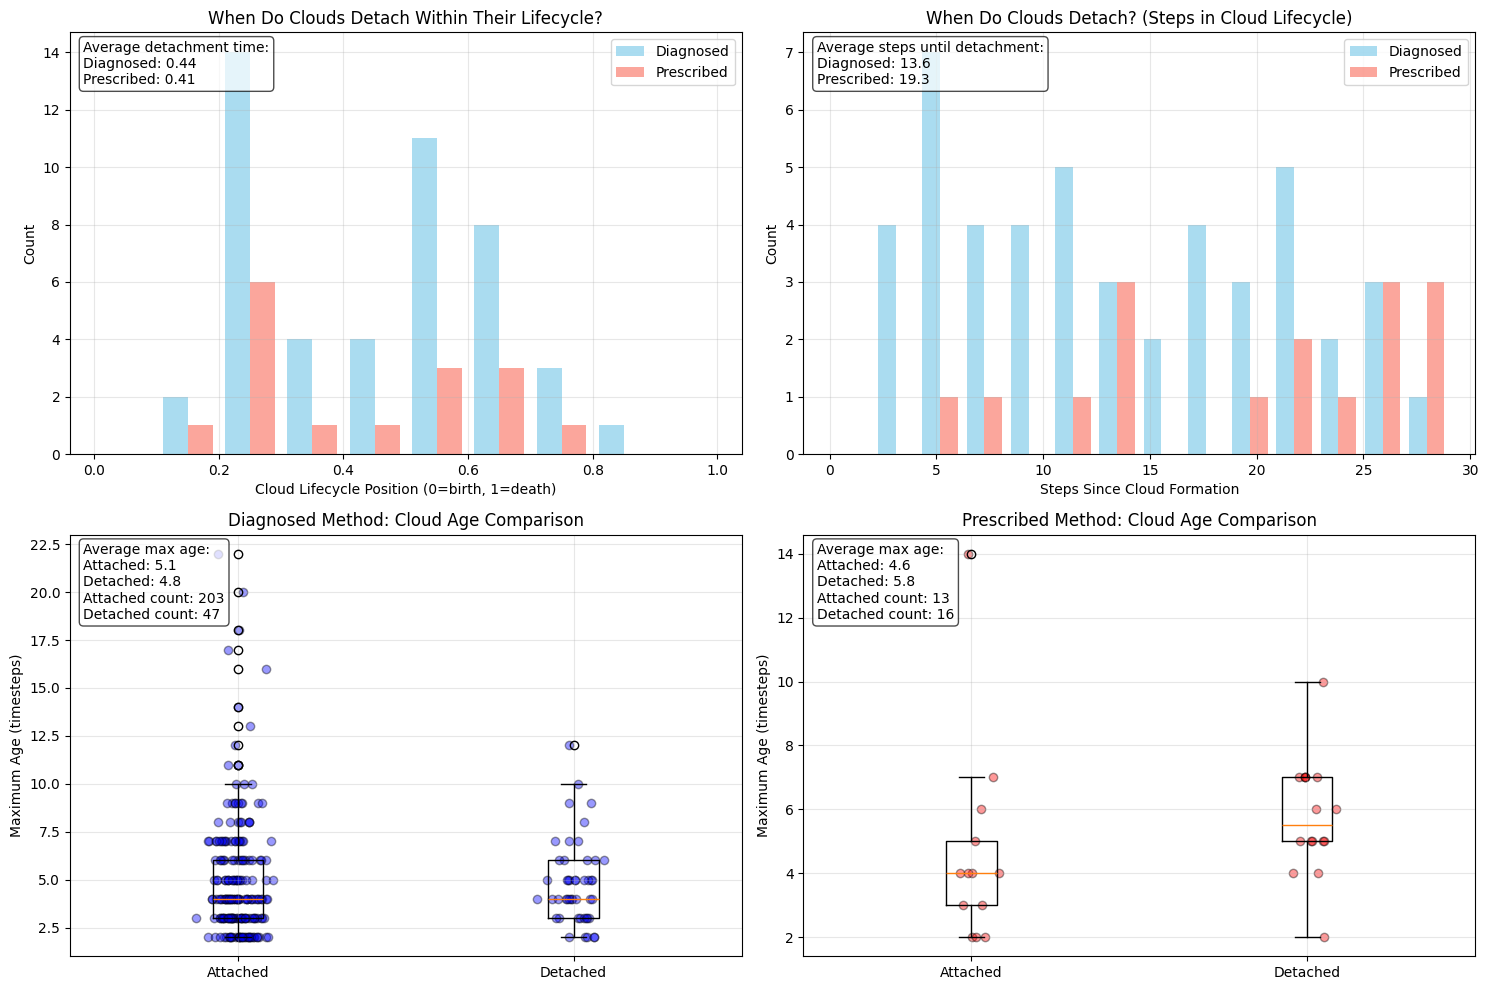

In [15]:
results = analyze_cloud_base_detachment_with_lifespan_plots(
    raw_data=raw,
    tracks_df=df_tracks,
    detachment_threshold=50,  # More strict definition of detachment
    min_lifetime_steps=3,      # Longer-lived clouds only
    min_size_points=20         # Larger clouds only
)

# Checking NIP

In [2]:
# PARAMETERS
nc_file = "../cloud_results.nc"
min_max_size_points = 100        # Track must reach at least this many voxels once
min_lifetime_steps = 3           # Track must exist (non-NaN size) at least this many timesteps
use_integrated_mass_flux = True  # If True: sum over time; else: time-mean
time_step_seconds = 60           # Needed only if you want to scale integrated flux by dt
volume_dx = 25.0                 # Horizontal grid (m)
volume_dy = 25.0                 # Horizontal grid (m)
# For voxel vertical thickness we infer per level (variable height spacing allowed)

# NIP analysis knobs
TIME_STRIDE = 1                  # analyze every Nth timestep
MAX_TRACKS_PER_T = 8000          # subsample tracks per timestep for speed
RANDOM_SEED = 42

# Optional: periodic domain lengths (m) for min-image distances
# If unknown, leave as None to use plain Euclidean
DOMAIN_LX = None
DOMAIN_LY = None

# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns
import math
import random

sns.set_context("talk")
sns.set_style("whitegrid")
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [3]:
def load_tracks(nc_path):
    def read_opt(ds, name):
        var = ds.variables.get(name)
        if var is None:
            return None
        data = var[:]
        if np.issubdtype(data.dtype, np.integer):
            return np.ma.filled(data.astype(np.float64), np.nan)
        else:
            return np.ma.filled(data, np.nan)

    with Dataset(nc_path) as ds:
        # Required
        valid_track = np.asarray(ds.variables['valid_track'][:])
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        mass_flux = np.ma.filled(ds.variables['mass_flux'][:], np.nan)
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        height = np.asarray(ds.variables['height'][:])
        # Optional extras (filled to NaN)
        age = read_opt(ds, 'age') 
        cloud_base_area = read_opt(ds, 'cloud_base_area')
        max_height = read_opt(ds, 'max_height')
        cloud_base_height = read_opt(ds, 'cloud_base_height')
        base_radius_diagnosed = read_opt(ds, 'base_radius_diagnosed')
        base_radius_prescribed = read_opt(ds, 'base_radius_prescribed')
        max_w_cloud_base = read_opt(ds, 'max_w_cloud_base')
        w_per_level = read_opt(ds, 'w_per_level')  # (track,time,level)
        surface_area = read_opt(ds, 'surface_area')

        # NIP related and kinematics/marks
        nip_per_level = read_opt(ds, 'nip_per_level')           # (track,time,level)
        nip_acc_per_level = read_opt(ds, 'nip_acc_per_level')   # (track,time,level)
        mass_flux_per_level = read_opt(ds, 'mass_flux_per_level')  # (track,time,level)
        loc_x = read_opt(ds, 'location_x')                      # (track,time)
        loc_y = read_opt(ds, 'location_y')                      # (track,time)

    return dict(
        valid_track=valid_track,
        size=size,
        mass_flux=mass_flux,
        merges_count=merges_count.astype(np.int32),
        splits_count=splits_count.astype(np.int32),
        height=height,
        age=age,
        cloud_base_area=cloud_base_area,
        max_height=max_height,
        cloud_base_height=cloud_base_height,
        base_radius_diagnosed=base_radius_diagnosed,
        base_radius_prescribed=base_radius_prescribed,
        max_w_cloud_base=max_w_cloud_base,
        surface_area=surface_area,
        w_per_level=w_per_level,
        # NIP and helpers
        nip_per_level=nip_per_level,
        nip_acc_per_level=nip_acc_per_level,
        mass_flux_per_level=mass_flux_per_level,
        location_x=loc_x,
        location_y=loc_y,
    )


In [4]:
def build_track_dataframe(data, min_max_size_points, min_lifetime_steps,
                          use_integrated_mass_flux, time_step_seconds,
                          voxel_volume_per_level=None):
    valid_mask = data['valid_track'] == 1
    size = np.asarray(data['size'])
    mass_flux = np.asarray(data['mass_flux'])
    merges = np.asarray(data['merges_count'])
    splits = np.asarray(data['splits_count'])

    n_tracks, n_time = size.shape
    records = []
    for i in range(n_tracks):
        if not valid_mask[i]:
            continue

        size_row = size[i]  # (time,)
        valid_timesteps = np.isfinite(size_row)
        lifetime = int(valid_timesteps.sum())
        if lifetime == 0:
            continue

        max_size = np.nanmax(size_row)
        if (max_size < min_max_size_points) or (lifetime < min_lifetime_steps):
            continue

        merges_total = int(merges[i, valid_timesteps].sum())
        splits_total = int(splits[i, valid_timesteps].sum())

        mf_row = mass_flux[i]
        if use_integrated_mass_flux:
            mf_val = np.nansum(mf_row[valid_timesteps])  # * time_step_seconds if desired
        else:
            mf_val = float(np.nanmean(mf_row[valid_timesteps]))

        mean_size = float(np.nanmean(size_row[valid_timesteps]))

        records.append(dict(track_index=i,
                            lifetime=lifetime,
                            max_size_points=max_size,
                            mean_size_points=mean_size,
                            merges_total=merges_total,
                            splits_total=splits_total,
                            mass_flux_metric=mf_val))
    return pd.DataFrame.from_records(records)

def infer_voxel_volumes(height, dx, dy):
    z = np.asarray(height, dtype=float)
    if z.size < 2:
        dz = np.array([1.0])
    else:
        dz_mid = np.diff(z)
        last = np.median(dz_mid)
        dz = np.concatenate([dz_mid, [last]])
    return dx * dy * dz

def categorize_merges(df):
    def cat(m):
        if m == 0: return "0"
        if m == 1: return "1"
        if m == 2: return "2"
        return "3+"
    return df.assign(merge_class=df.merges_total.map(cat),
                     merged_flag=(df.merges_total > 0))

# NIP helpers
def nearest_level_index(levels, target):
    L = levels.shape[0]
    tgt = np.asarray(target)
    out = np.full(tgt.shape, -1, dtype=int)
    mask = np.isfinite(tgt)
    if not np.any(mask):
        return out
    diffs = np.abs(levels[None, :] - tgt[mask, None])
    idx = np.argmin(diffs, axis=1)
    out[mask] = idx
    return out

def choose_valid_indices(mask, max_n):
    idx = np.where(mask)[0]
    if idx.size <= max_n:
        return idx
    return np.random.choice(idx, size=max_n, replace=False)

def pairwise_min_image_dist(x, y, Lx=None, Ly=None):
    n = x.shape[0]
    if n < 2:
        return np.array([np.nan])
    dists_nn = np.full(n, np.nan, dtype=float)
    for i in range(n):
        dx = x - x[i]
        dy = y - y[i]
        if Lx is not None:
            dx = ((dx + 0.5*Lx) % Lx) - 0.5*Lx
        if Ly is not None:
            dy = ((dy + 0.5*Ly) % Ly) - 0.5*Ly
        d = np.hypot(dx, dy)
        d[i] = np.inf
        dists_nn[i] = np.min(d)
    return dists_nn

def recompute_proxy_nip(x, y, w_mark, Lh_proxy, Lx=None, Ly=None):
    # NIP-like sum without kinematic boost: sum_j mark_j * exp(-d_ij/Lh)
    n = x.size
    out = np.zeros(n, dtype=float)
    for i in range(n):
        dx = x - x[i]
        dy = y - y[i]
        if Lx is not None:
            dx = ((dx + 0.5*Lx) % Lx) - 0.5*Lx
        if Ly is not None:
            dy = ((dy + 0.5*Ly) % Ly) - 0.5*Ly
        d = np.hypot(dx, dy)
        d[i] = np.inf
        out[i] = np.nansum(w_mark * np.exp(-d / Lh_proxy))
    return out


In [5]:
raw = load_tracks(nc_file)
voxel_vol = infer_voxel_volumes(raw['height'], volume_dx, volume_dy)  # optional

df_tracks = build_track_dataframe(raw,
                                  min_max_size_points=min_max_size_points,
                                  min_lifetime_steps=min_lifetime_steps,
                                  use_integrated_mass_flux=use_integrated_mass_flux,
                                  time_step_seconds=time_step_seconds)
df_tracks = categorize_merges(df_tracks)

n_tracks, n_times = raw['size'].shape
n_levels = raw['height'].shape[0]
print(f"Tracks: {n_tracks}, Times: {n_times}, Levels: {n_levels}")
print(f"Valid complete tracks: {int(np.sum(raw['valid_track'] == 1))}")
print(df_tracks.describe(include='all'))


Tracks: 100000, Times: 10, Levels: 160
Valid complete tracks: 99986
        track_index  lifetime  max_size_points  mean_size_points  \
count       2.00000       2.0         2.000000          2.000000   
unique          NaN       NaN              NaN               NaN   
top             NaN       NaN              NaN               NaN   
freq            NaN       NaN              NaN               NaN   
mean       11.50000       4.0       309.500000        205.125000   
std         2.12132       0.0        38.890873         23.864854   
min        10.00000       4.0       282.000000        188.250000   
25%        10.75000       4.0       295.750000        196.687500   
50%        11.50000       4.0       309.500000        205.125000   
75%        12.25000       4.0       323.250000        213.562500   
max        13.00000       4.0       337.000000        222.000000   

        merges_total  splits_total  mass_flux_metric merge_class merged_flag  
count            2.0      2.000000  

NIP base-level samples: 22
Base NIP: median=0.000, IQR=(0.000,0.000)
Base NIP_acc: median=0.000


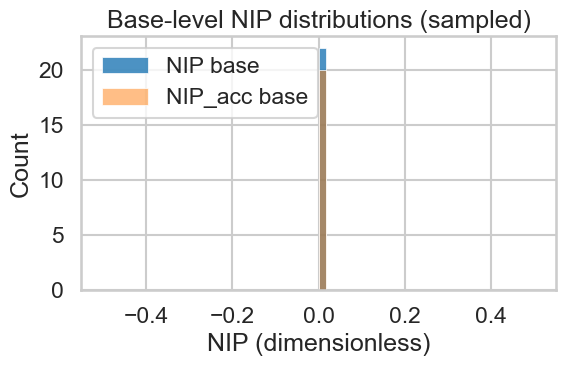

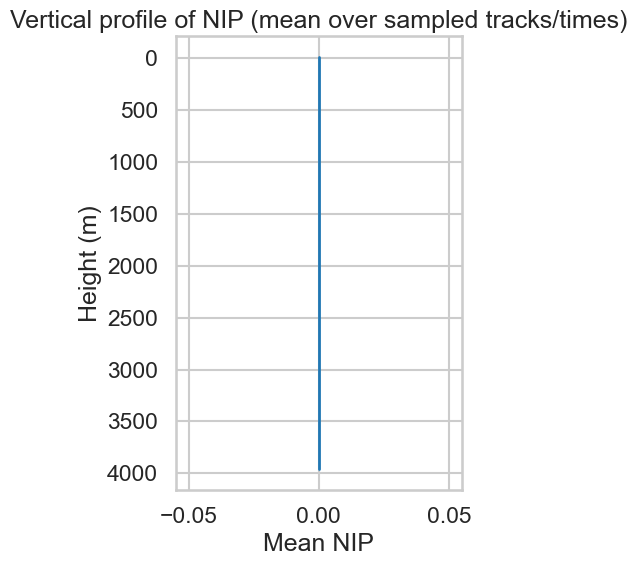

In [6]:
nip = raw['nip_per_level']
nip_acc = raw['nip_acc_per_level']
cbh = raw['cloud_base_height']
height = raw['height']
valid_track = raw['valid_track'] == 1

if nip is None or nip_acc is None or cbh is None:
    raise RuntimeError("NIP fields or cloud_base_height missing in NetCDF. Re-run tracking with NIP enabled.")

nip_base_all = []
nip_acc_base_all = []
lev_profile_sum = np.zeros(n_levels)
lev_profile_count = np.zeros(n_levels, dtype=int)

for t in range(0, n_times, TIME_STRIDE):
    nip_t = nip[:, t, :]                  # (track, level)
    nip_acc_t = nip_acc[:, t, :]
    base_h = cbh[:, t]                    # (track,)
    has_any = np.isfinite(nip_t).any(axis=1)
    mask = valid_track & has_any & np.isfinite(base_h)
    sel = choose_valid_indices(mask, MAX_TRACKS_PER_T)
    if sel.size == 0:
        continue

    base_idx = nearest_level_index(height, base_h[sel])
    ok = base_idx >= 0
    if not np.any(ok):
        continue
    ii = sel[ok]
    jj = base_idx[ok]

    nip_b = nip_t[ii, jj]
    nip_acc_b = nip_acc_t[ii, jj]
    nip_base_all.append(nip_b[np.isfinite(nip_b)])
    nip_acc_base_all.append(nip_acc_b[np.isfinite(nip_acc_b)])

    # Vertical profile aggregates
    finite_mask = np.isfinite(nip_t[ii, :])
    lev_profile_sum += np.nan_to_num(nip_t[ii, :], nan=0.0).sum(axis=0)
    lev_profile_count += finite_mask.sum(axis=0)

nip_base_all = np.concatenate(nip_base_all) if nip_base_all else np.array([])
nip_acc_base_all = np.concatenate(nip_acc_base_all) if nip_acc_base_all else np.array([])

print(f"NIP base-level samples: {nip_base_all.size}")
if nip_base_all.size:
    print(f"Base NIP: median={np.nanmedian(nip_base_all):.3f}, IQR=({np.nanpercentile(nip_base_all,25):.3f},{np.nanpercentile(nip_base_all,75):.3f})")
if nip_acc_base_all.size:
    print(f"Base NIP_acc: median={np.nanmedian(nip_acc_base_all):.3f}")

plt.figure(figsize=(6,4))
if nip_base_all.size:
    sns.histplot(nip_base_all, bins=60, color='tab:blue', alpha=0.8, label='NIP base')
if nip_acc_base_all.size:
    sns.histplot(nip_acc_base_all, bins=60, color='tab:orange', alpha=0.5, label='NIP_acc base')
plt.xlabel('NIP (dimensionless)')
plt.ylabel('Count')
plt.title('Base-level NIP distributions (sampled)')
plt.legend()
plt.tight_layout()
plt.show()

mean_profile = np.divide(lev_profile_sum, np.maximum(lev_profile_count, 1), where=(lev_profile_count>0))
plt.figure(figsize=(4.5,6))
plt.plot(mean_profile, height, lw=2)
plt.gca().invert_yaxis()
plt.xlabel('Mean NIP')
plt.ylabel('Height (m)')
plt.title('Vertical profile of NIP (mean over sampled tracks/times)')
plt.tight_layout()
plt.show()


Pairs (NIP_base, ΔMassFlux): (10, 2)
Pearson r(NIP_base, ΔMassFlux next) = nan


/Users/jure/PhD/coding/tracking/cloudtracker/ct_venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jure/PhD/coding/tracking/cloudtracker/ct_venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


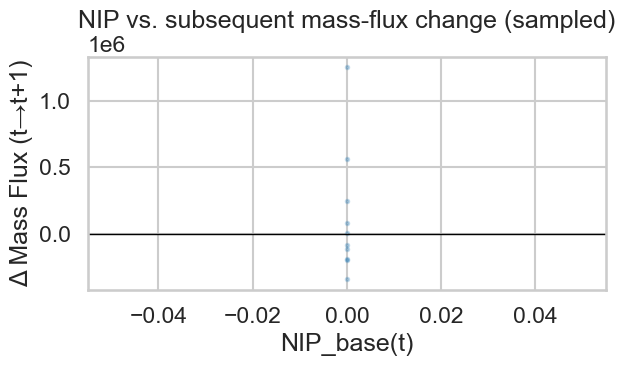

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_14315/1541003216.py:50: RuntimeWarning: Mean of empty slice
  mean_by_bin = [np.nanmean(pairs[bins==k,1]) for k in range(10)]


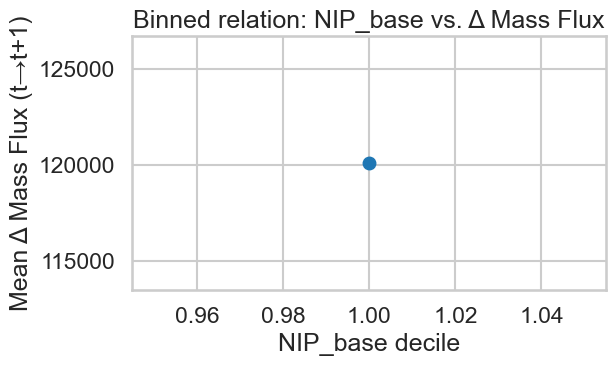

In [7]:
mf = raw['mass_flux']
pairs = []

for t in range(0, n_times-1, TIME_STRIDE):
    nip_t = nip[:, t, :]
    base_h_t = cbh[:, t]
    mf_t = mf[:, t]
    mf_next = mf[:, t+1]

    mask = (valid_track &
            np.isfinite(base_h_t) &
            np.isfinite(mf_t) & np.isfinite(mf_next) &
            np.isfinite(nip_t).any(axis=1))
    sel = choose_valid_indices(mask, MAX_TRACKS_PER_T)
    if sel.size == 0:
        continue

    base_idx = nearest_level_index(height, base_h_t[sel])
    ok = base_idx >= 0
    if not np.any(ok):
        continue
    ii = sel[ok]; jj = base_idx[ok]

    nip_base = nip_t[ii, jj]
    dmf = mf_next[ii] - mf_t[ii]

    m = np.isfinite(nip_base) & np.isfinite(dmf)
    if np.any(m):
        pairs.append(np.column_stack([nip_base[m], dmf[m]]))

pairs = np.vstack(pairs) if pairs else np.zeros((0,2))
print(f"Pairs (NIP_base, ΔMassFlux): {pairs.shape}")
if pairs.shape[0] > 0:
    corr = np.corrcoef(pairs[:,0], pairs[:,1])[0,1]
    print(f"Pearson r(NIP_base, ΔMassFlux next) = {corr:.3f}")

    sample = pairs[np.random.choice(pairs.shape[0], size=min(8000, pairs.shape[0]), replace=False)]
    plt.figure(figsize=(6.5,4))
    plt.scatter(sample[:,0], sample[:,1], s=6, alpha=0.25)
    plt.axhline(0, color='k', lw=1)
    plt.xlabel('NIP_base(t)')
    plt.ylabel('Δ Mass Flux (t→t+1)')
    plt.title('NIP vs. subsequent mass-flux change (sampled)')
    plt.tight_layout()
    plt.show()

    # Decile-binned mean ΔM for clearer signal
    q = np.nanquantile(pairs[:,0], np.linspace(0,1,11))
    bins = np.digitize(pairs[:,0], q[1:-1], right=True)
    mean_by_bin = [np.nanmean(pairs[bins==k,1]) for k in range(10)]
    plt.figure(figsize=(6.5,4))
    plt.plot(np.arange(1,11), mean_by_bin, marker='o')
    plt.xlabel('NIP_base decile')
    plt.ylabel('Mean Δ Mass Flux (t→t+1)')
    plt.title('Binned relation: NIP_base vs. Δ Mass Flux')
    plt.tight_layout()
    plt.show()
